In [8]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### CS Misclassification Prediction

In [12]:
method_transform = {
    'Vanilla': 'Vanilla',
    'Entropy': 'Entropy',
    'ModelWithTemperature': 'Temp Scale',
    'ModelActivateDropout': 'MC-Dropout',
    'Mutation': 'mMutant',
    'PVScore': 'Dissector',
}
task_transform = {
    'CodeSummary_Module': 'Method name prediction',
    'CodeCompletion_Module': 'Code completion',
}
shift_intensity_names = {
    'Validation': 'BigCloneEval (in-dist.)',
    'Shifted': 'Ruoyiplus (shifted)',
}

dir = '../Uncertainty_Eval/'
task = 'CodeSummary_Module'
shift = 'case_study'
csmodels = ['code2vec', 'coderoberta', 'graphcodebert']
ccmodels = ['lstm', 'codebert', 'codegpt']

record = []
if task == 'CodeSummary_Module':
    models = csmodels
else:
    models = ccmodels
for model in models:
    res = torch.load(os.path.join(dir, shift, model, task, 'uncertainty_eval.res'))
    for ue, outputs in res.items():
        auc_res = outputs['AUC']
        aupr_res = outputs['AUPR']
        brier_res = outputs['Brier']
        if ue in ['Mutation', 'PVScore']:
            auc_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUC',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': auc_res[0]['val']*100,
                'Shifted': auc_res[0]['test']*100,
            }
            aupr_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUPR',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': aupr_res[0]['val']*100,
                'Shifted': aupr_res[0]['test']*100,
            }
            brier_ins = {
                'Method': method_transform[ue],
                'Metric': 'Brier',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': brier_res[0]['val']*100,
                'Shifted': brier_res[0]['test']*100,
            }
        else:
            auc_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUC',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': auc_res['val']*100,
                'Shifted': auc_res['test']*100,
            }
            aupr_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUPR',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': aupr_res['val']*100,
                'Shifted': aupr_res['test']*100,
            }
            brier_ins = {
                'Method': method_transform[ue],
                'Metric': 'Brier',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': brier_res['val']*100,
                'Shifted': brier_res['test']*100,
            }
        record.append(auc_ins)
        record.append(aupr_ins)
        record.append(brier_ins)
    
cs_df = pd.DataFrame(record)
cs_df_auc = cs_df[cs_df['Metric'] == 'AUC']
cs_df_aupr = cs_df[cs_df['Metric'] == 'AUPR']
cs_df_brier = cs_df[cs_df['Metric'] == 'Brier']

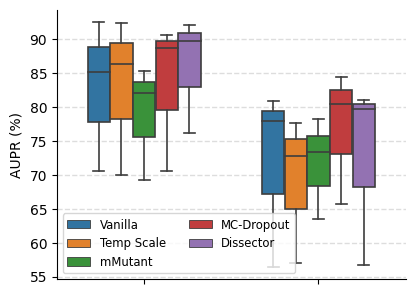

In [3]:
cs_df_aupr = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUPR'] * 6 * 3,
    'Shift': ['case_study'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': np.array([72.991588, 73.261439, 72.168848, 73.495597, 73.495267, 79.102488,                   
                   89.343723, 88.501620, 88.259206, 88.204457, 93.676390, 92.773176,                   
                   95.436794, 95.569908, 85.066943, 95.570807, 91.677813, 95.052673])-3,
    'Shifted': np.array([60.009557, 57.040653, 66.491577, 59.436451, 68.679519, 59.651957,                
                75.800513, 81.322539, 81.209505, 80.992728, 87.482783, 84.041997,                
                80.670046, 83.860030, 76.298782, 83.915047, 83.483807, 82.733785])-3,
})

# Reshape the data using melt function
cs_aupr_melt = pd.melt(
    cs_df_aupr, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shifted'],
    var_name='Shift_Intensity', 
    value_name='AUPR',
)
cs_aupr_melt['Shift_Intensity'] = cs_aupr_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(4.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=cs_aupr_melt, 
    x='Shift_Intensity', 
    y='AUPR', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
# set the y-axis tick labels as integers
ax.set_xticklabels(['']*2)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('')
plt.ylabel('AUPR (%)')
plt.savefig('../Figure/case_cs_aupr.pdf', bbox_inches='tight')
plt.show()

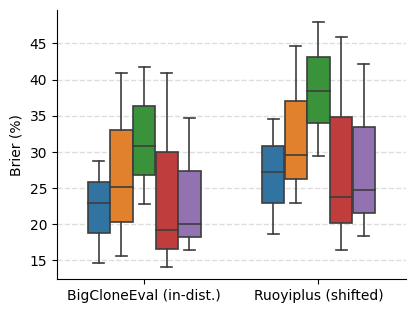

In [125]:
cs_df_brier = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['Brier'] * 6 * 3,
    'Shift': ['case_study'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [25.181279, 24.142796, 41.765028, 22.956105, 40.914721, 34.623968,                    
                   40.848295, 35.886321, 22.819711, 28.747549, 14.056281, 16.447430,                    
                   15.520990, 19.534792, 30.822975, 14.601129, 19.137399, 20.023761],
    'Shifted': [29.518048, 29.522968, 47.968802, 27.150621, 45.947451, 42.105448,                 
                44.644252, 41.705217, 29.483023, 34.481647, 16.450679, 18.283575,                 
                22.942355, 23.583005, 38.412548, 18.654084, 23.806263, 24.682076],
})
# Reshape the data using melt function
cs_brier_melt = pd.melt(
    cs_df_brier, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shifted'],
    var_name='Shift_Intensity', 
    value_name='Brier',
)
cs_brier_melt['Shift_Intensity'] = cs_brier_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(4.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=cs_brier_melt, 
    x='Shift_Intensity', 
    y='Brier', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(ncols=2, fontsize='small')
ax.legend([],[], frameon=False)
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('')
plt.ylabel('Brier (%)')
plt.savefig('../Figure/case_cs_brier.pdf', bbox_inches='tight')
plt.show()

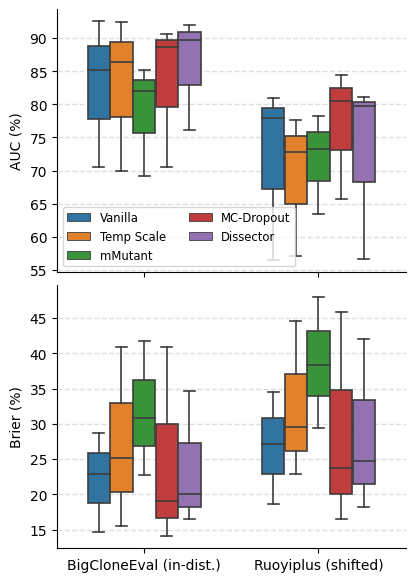

In [126]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(4.5, 7), sharex=True)
ax1.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax2.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)

# Plot AUPR boxplot on first subplot
sns.boxplot(
    data=cs_aupr_melt,
    x='Shift_Intensity',
    y='AUPR',
    hue='Method',
    hue_order=method_order,
    width=0.65,
    linewidth=1.2,
    ax=ax1,
)
ax1.set_axisbelow(True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(ncols=2, fontsize='small')
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('AUC (%)')

# Plot Brier boxplot on second subplot
sns.boxplot(
    data=cs_brier_melt,
    x='Shift_Intensity',
    y='Brier',
    hue='Method',
    hue_order=method_order,
    width=0.65,
    linewidth=1.2,
    ax=ax2,
)
ax2.set_axisbelow(True)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend([],[], frameon=False)
ax2.set_title('')
ax2.set_xlabel('')
ax2.set_ylabel('Brier (%)')

# Set y-axis tick labels as integers for both subplots
ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

# Remove space between subplots
plt.subplots_adjust(hspace=0.05)
plt.savefig('../Figure/case_cs.pdf', bbox_inches='tight')

# Show the plot
plt.show()

### CC Misclassification Prediction

In [13]:
dir = '../Uncertainty_Eval/'
task = 'CodeCompletion_Module'
shift = 'case_study'

record = []
if task == 'CodeSummary_Module':
    models = csmodels
else:
    models = ccmodels
for model in models:
    res = torch.load(os.path.join(dir, shift, model, task, 'uncertainty_eval.res'))
    for ue, outputs in res.items():
        auc_res = outputs['AUC']
        aupr_res = outputs['AUPR']
        brier_res = outputs['Brier']
        if ue in ['Mutation', 'PVScore']:
            auc_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUC',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': auc_res[0]['val']*100,
                'Shifted': auc_res[0]['test']*100,
            }
            aupr_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUPR',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': aupr_res[0]['val']*100,
                'Shifted': aupr_res[0]['test']*100,
            }
            brier_ins = {
                'Method': method_transform[ue],
                'Metric': 'Brier',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': brier_res[0]['val']*100,
                'Shifted': brier_res[0]['test']*100,
            }
        else:
            auc_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUC',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': auc_res['val']*100,
                'Shifted': auc_res['test']*100,
            }
            aupr_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUPR',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': aupr_res['val']*100,
                'Shifted': aupr_res['test']*100,
            }
            brier_ins = {
                'Method': method_transform[ue],
                'Metric': 'Brier',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': brier_res['val']*100,
                'Shifted': brier_res['test']*100,
            }
        record.append(auc_ins)
        record.append(aupr_ins)
        record.append(brier_ins)
    
cc_df = pd.DataFrame(record)
cc_df_auc = cc_df[cc_df['Metric'] == 'AUC']
cc_df_aupr = cc_df[cc_df['Metric'] == 'AUPR']
cc_df_brier = cc_df[cc_df['Metric'] == 'Brier']

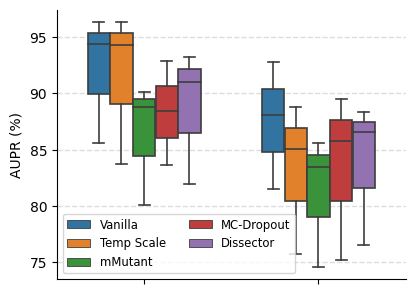

In [5]:
cc_df_aupr = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUPR'] * 6 * 3,
    'Shift': ['case_study'] * 6 * 3,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [94.310886, 96.028657, 88.82424, 94.380813, 88.437638, 91.057344, 
                83.77862, 89.611762, 80.073376, 85.582611, 83.681013, 81.99671, 
                96.360327, 95.96581, 90.118653, 96.323769, 92.859405, 93.230995],
    'Shifted': [85.105414, 84.586621, 83.460103, 88.108229, 85.741485, 86.616888,
                75.779079, 77.591379, 74.595693, 81.548549, 75.200687, 76.507742,
                88.787705, 85.332301, 85.623871, 92.764199, 89.550278, 88.320614],
})
# Reshape the data using melt function
cc_aupr_melt = pd.melt(
    cc_df_aupr, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shifted'],
    var_name='Shift_Intensity', 
    value_name='AUPR',
)
cc_aupr_melt['Shift_Intensity'] = cc_aupr_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(4.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=cc_aupr_melt, 
    x='Shift_Intensity', 
    y='AUPR', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
# set the y-axis tick labels as integers
ax.set_xticklabels(['']*2)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('')
plt.ylabel('AUPR (%)')
plt.savefig('../Figure/case_cc_aupr.pdf', bbox_inches='tight')
plt.show()

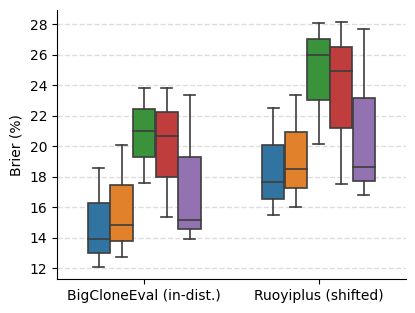

In [134]:
cc_df_brier = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['Brier'] * 6 * 3,
    'Shift': ['case_study'] * 6 * 3,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [12.759712, 12.413041, 17.571994, 12.076992, 20.637525, 15.188627,            
                   20.101890, 17.313177, 23.836636, 18.594386, 23.784081, 23.334789,            
                   14.808706, 13.378044, 21.013538, 13.900978, 15.355761, 13.899201],
    'Shifted': [16.024493, 14.023432, 20.116393, 15.496614, 28.135616, 16.802571,               
                23.364859, 18.460662, 28.061970, 22.512377, 24.899068, 27.668945,               
                18.520850, 14.196060, 25.990188, 17.625420, 17.497597, 18.604441],
})
# Reshape the data using melt function
cc_brier_melt = pd.melt(
    cc_df_brier, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shifted'],
    var_name='Shift_Intensity', 
    value_name='Brier',
)
cc_brier_melt['Shift_Intensity'] = cc_brier_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(4.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=cc_brier_melt, 
    x='Shift_Intensity', 
    y='Brier', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(ncols=2, fontsize='small')
ax.legend([],[], frameon=False)
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('')
plt.ylabel('Brier (%)')
plt.savefig('../Figure/case_cc_brier.pdf', bbox_inches='tight')
plt.show()

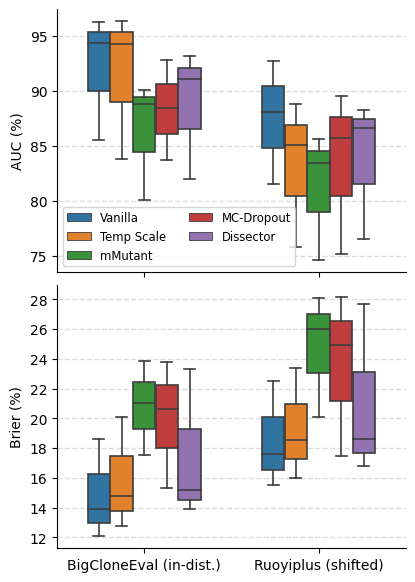

In [135]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(4.5, 7), sharex=True)
ax1.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax2.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)

# Plot AUPR boxplot on first subplot
sns.boxplot(
    data=cc_aupr_melt,
    x='Shift_Intensity',
    y='AUPR',
    hue='Method',
    hue_order=method_order,
    width=0.65,
    linewidth=1.2,
    ax=ax1,
)
ax1.set_axisbelow(True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(ncols=2, fontsize='small')
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('AUC (%)')

# Plot Brier boxplot on second subplot
sns.boxplot(
    data=cc_brier_melt,
    x='Shift_Intensity',
    y='Brier',
    hue='Method',
    hue_order=method_order,
    width=0.65,
    linewidth=1.2,
    ax=ax2,
)
ax2.set_axisbelow(True)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend([],[], frameon=False)
ax2.set_title('')
ax2.set_xlabel('')
ax2.set_ylabel('Brier (%)')

# Set y-axis tick labels as integers for both subplots
ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

# Remove space between subplots
plt.subplots_adjust(hspace=0.05)
plt.savefig('../Figure/case_cc.pdf', bbox_inches='tight')

# Show the plot
plt.show()

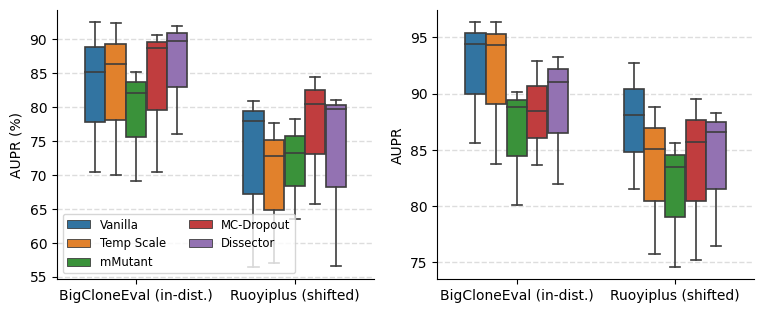

In [7]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 3.5), sharex=True)
ax1.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax2.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)

# Plot AUPR boxplot on first subplot
sns.boxplot(
    data=cs_aupr_melt,
    x='Shift_Intensity',
    y='AUPR',
    hue='Method',
    hue_order=method_order,
    width=0.65,
    linewidth=1.2,
    ax=ax1,
)
ax1.set_axisbelow(True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(ncols=2, fontsize='small')
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('AUPR (%)')

# Plot Brier boxplot on second subplot
sns.boxplot(
    data=cc_aupr_melt,
    x='Shift_Intensity',
    y='AUPR',
    hue='Method',
    hue_order=method_order,
    width=0.65,
    linewidth=1.2,
    ax=ax2,
)
ax2.set_axisbelow(True)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend([],[], frameon=False)
ax2.set_title('')
ax2.set_xlabel('')
# ax2.set_ylabel('Brier (%)')

# Set y-axis tick labels as integers for both subplots
ax1.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

# Remove space between subplots
plt.subplots_adjust(hspace=0.05)
plt.savefig('../Figure/case_aupr.pdf', bbox_inches='tight')

# Show the plot
plt.show()

### Efficiency Study

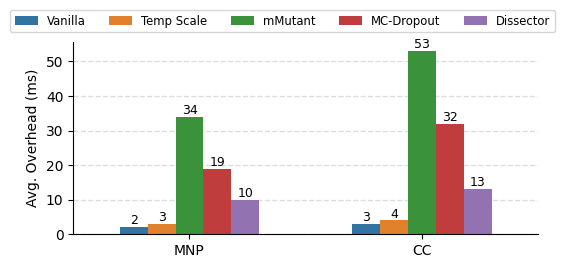

In [47]:
shift_intensity_names = {
    'CS_time': 'MNP',
    'CC_time': 'CC',
}

# Define the data
time = [
    {"Method": 'Vanilla', "CS_time": 2, "CC_time": 3},
    {"Method": 'Temp Scale', "CS_time": 3, "CC_time": 4},
    {"Method": 'mMutant', "CS_time": 34, "CC_time": 53},
    {"Method": 'MC-Dropout', "CS_time": 19, "CC_time": 32},
    {"Method": 'Dissector', "CS_time": 10, "CC_time": 13},
]
time_df = pd.DataFrame(time)
# Reshape the data using melt function"
time_melt = pd.melt(
    time_df, 
    id_vars='Method',
    value_vars=['CS_time', 'CC_time'],
    var_name='Task', 
    value_name='Time',
)
time_melt['Task'] = time_melt['Task'].map(shift_intensity_names)

# Plot barplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6, 2.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.barplot(
    data=time_melt, 
    x='Task', 
    y='Time', 
    hue='Method', 
    hue_order=method_order, 
    width=0.6,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=5, fontsize='small', loc='lower center', bbox_to_anchor=(0.45, 1.02))
# ax.legend([],[], frameon=False)
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
# Add values on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9)
plt.title('')
plt.xlabel('')
plt.ylabel('Avg. Overhead (ms)')
plt.savefig('../Figure/case_overhead.pdf', bbox_inches='tight')
plt.show()

In [2]:
import torch
cc_dropout = torch.load("../Uncertainty_Results/different_author/codebert/CodeCompletion_Module/ModelWithTemperature.res")
cs_dropout = torch.load("../Uncertainty_Results/different_author/graphcodebert/CodeSummary_Module/ModelWithTemperature.res")

/home/yuli/anaconda3/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
cc_dropout['val'].shape

(98528,)